In [1]:
%matplotlib widget

In [2]:
import numpy as np
from pathlib import Path
from skimage import io
from bouter.utilities import fast_pearson, fast_corrcoef
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.colors import hex2color
from lotr.plotting import add_anatomy_scalebar, add_cbar
from lotr import DATASET_LOCATION

In [4]:
path = DATASET_LOCATION.parent / "2p_data" / "2p_2d_corr"

anatomy = io.imread(path/"anatomy.tif", plugin="tifffile")
bins = io.imread(path/"bins.tif", plugin="tifffile")
traces = np.load(path/"traces.npy", allow_pickle=True)
traces_x = np.load(path/"traces_x.npy", allow_pickle=True)
traces_y = np.load(path/"traces_y.npy", allow_pickle=True)

#### Fig5c

In [5]:
plane = 6
bin_px = 10
crop = slice(20,-20)

traces_plane = traces[plane]
anatomy_plane = anatomy[crop,crop]
bins_plane = bins[plane,crop,crop]

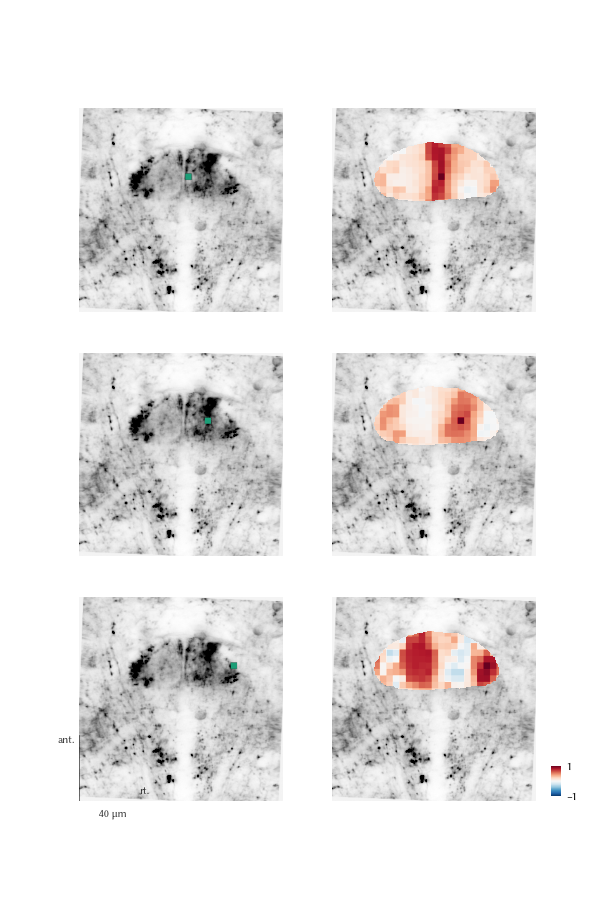

In [6]:
px_size = 0.35
selected_bins = [105, 135, 175]
vmax = np.percentile(anatomy, 99)
extent = (0, px_size*anatomy.shape[-1],)*2

fig, ax = plt.subplots(3,2, figsize=(6,9))

for i, this_bin in enumerate(selected_bins):
    this = traces_plane[this_bin,:]
    corr_img = bins_plane.copy()
    for b in range(traces_plane.shape[0]):
        that = traces_plane[b,:]
        if not np.isnan(that).all():
            corr_img[corr_img==b] = fast_pearson(this, that)
    bin_img = np.zeros(anatomy_plane.shape + (4,))
    bin_img[bins_plane==this_bin, :] = hex2color("#1b9e77") + (1,)
    ax[i,0].imshow(anatomy.T, cmap="gray_r", vmax=vmax, extent=extent, origin="upper")
    ax[i,0].imshow(bin_img.transpose(1,0,2), extent=extent, origin="upper")
    ax[i,1].imshow(anatomy.T, cmap="gray_r", vmax=vmax, extent=extent, origin="upper")
    im = ax[i,1].imshow(corr_img.T, cmap="RdBu_r", vmax=1, vmin=-1, extent=extent, origin="upper")

for a in ax.flat:
    a.axis("off")
    
add_anatomy_scalebar(ax[i,0], pos=[0,0], length=40, fontsize=8)
add_cbar(im, ax[i,1], inset_loc=(1.1, 0.05, 0.05, 0.15), ticks=(-1,1))

#### Fig5d

In [7]:
bin_px = 10

pooled = []
x_pooled = []
y_pooled = []

for plane in range(len(traces)):
    this = traces[plane]
    this_x = traces_x[plane]
    this_y = traces_y[plane]
    
    n_bin_x = len(this_x)
    n_bin_y = len(this_y)
   
    cor = fast_corrcoef(this)
    mx = np.full((n_bin_x*n_bin_y, n_bin_x*2-1, n_bin_y*2-1), np.nan)
    for i in range(len(cor)):
        if not np.isnan(cor[i,np.arange(len(cor))!=i]).all():
            x0 = i//n_bin_y
            y0 = i%n_bin_y
            for j in range(len(cor)):
                x = j//n_bin_y
                y = j%n_bin_y
                mx[x0*n_bin_y+y0, x-x0+n_bin_x-1, y-y0+n_bin_y-1] = cor[i,j]
    pooled.append(np.nanmean(mx, axis=0))
    
    cor = fast_corrcoef(this_x)
    mx = np.full((n_bin_x, n_bin_x*2-1), np.nan)
    for i0 in range(len(cor)):
        for i in range(len(cor)):
            mx[i0, i-i0+n_bin_x-1] = cor[i0,i]
    x_pooled.append(np.nanmean(mx, axis=0))

    cor = fast_corrcoef(this_y)
    mx = np.full((n_bin_y, n_bin_y*2-1), np.nan)
    for i0 in range(len(cor)):
        for i in range(len(cor)):
            mx[i0, i-i0+n_bin_y-1] = cor[i0,i]
    y_pooled.append(np.nanmean(mx, axis=0))

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_92776/2288200517.py:25: RuntimeWarning: Mean of empty slice
  pooled.append(np.nanmean(mx, axis=0))


In [8]:
x_size = np.array([m.shape[0] for m in pooled]).max()
y_size = np.array([m.shape[1] for m in pooled]).max()

pooled_pad = np.full((len(pooled), x_size, y_size), np.nan)
for i, m in enumerate(pooled):
    x_diff = x_size-m.shape[0]
    y_diff = y_size-m.shape[1]
    pooled_pad[i,:,:] = np.pad(m, ((x_diff//2, x_diff//2), (y_diff//2, y_diff//2)), mode='constant', constant_values=np.nan)
    
x_pooled_pad = np.full((len(pooled), x_size), np.nan)
for i, m in enumerate(x_pooled):
    diff = x_size-m.shape[0]
    x_pooled_pad[i,:] = np.pad(m, diff//2, mode='constant', constant_values=np.nan)
    
y_pooled_pad = np.full((len(pooled), y_size), np.nan)
for i, m in enumerate(y_pooled):
    diff = y_size-m.shape[0]
    y_pooled_pad[i,:] = np.pad(m, diff//2, mode='constant', constant_values=np.nan)

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_92776/1509880596.py:4: RuntimeWarning: Mean of empty slice
  mx = np.nanmean(pooled_pad, axis=0)


(-0.13087642563673246, 1.053851258363654, -0.2, 20.2)

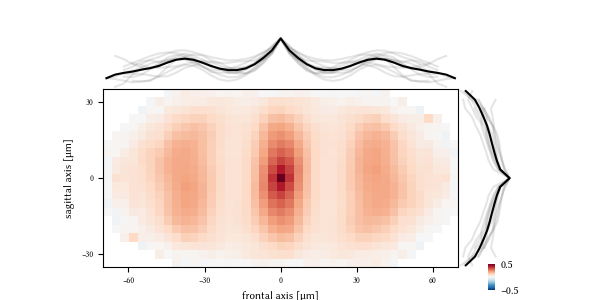

In [9]:
px_size = 0.35
x_ext = (x_size//2)*bin_px*px_size
y_ext = (y_size//2)*bin_px*px_size
mx = np.nanmean(pooled_pad, axis=0)
lim = np.ceil(np.maximum(np.nanmax(mx[mx!=1]), abs(np.nanmin(mx)))*10)/10

fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(2, 2, width_ratios=[11.5,1.5], height_ratios=[3,10], wspace=0, hspace=0)

ax = fig.add_subplot(gs[1,0])
im = ax.imshow(mx.T, vmin=-lim, vmax=lim, extent=(-x_ext, x_ext, -y_ext, y_ext), cmap='RdBu_r', origin="upper")
ax.xaxis.set(ticks_position='bottom')
ax.tick_params(labelsize=6)
ax.set(aspect="equal", xticks=np.linspace(-60, 60, 5), yticks=np.linspace(-30, 30, 3), xlabel="frontal axis [μm]", ylabel="sagittal axis [μm]")
mx_bbox = ax.get_position()
add_cbar(im, ax, inset_loc=(1.1, -0.1, 0.02, 0.15), ticks=(-lim,lim))

ax = fig.add_subplot(gs[0,0])
bbox = ax.get_position()
for i in range(len(x_pooled_pad)):
    ax.plot(x_pooled_pad[i,:], color="gray", alpha=0.2)
ax.plot(np.nanmean(x_pooled_pad, axis=0), c='k')
ax.margins(x=0.01)
ax.set(position=[mx_bbox.x0, mx_bbox.y0+mx_bbox.height, mx_bbox.width, bbox.height])
ax.axis('off')

ax = fig.add_subplot(gs[1,1])
bbox = ax.get_position()
for i in range(len(y_pooled_pad)):
    ax.plot(y_pooled_pad[i,:], range(y_size), color="gray", alpha=0.2)
ax.plot(np.nanmean(y_pooled_pad, axis=0), range(y_size), c='k')
ax.margins(y=0.01)
ax.set(position=[mx_bbox.x0+mx_bbox.width, mx_bbox.y0, bbox.width, mx_bbox.height])
ax.axis('off')

#### SupFig21

In [10]:
bin_px = 10

pooled = []
x_pooled = []
y_pooled = []

for plane in range(len(traces)):
    this = traces[plane]
    this_x = traces_x[plane]
    this_y = traces_y[plane]
    
    n_bin_x = len(this_x)
    n_bin_y = len(this_y)
   
    cor = fast_corrcoef(this)
    mx = np.full((n_bin_x*n_bin_y, n_bin_x*2-1, n_bin_y*2-1), np.nan)
    for i in range(len(cor)):
        if not np.isnan(cor[i,np.arange(len(cor))!=i]).all():
            x0 = i//n_bin_y
            y0 = i%n_bin_y
            for j in range(len(cor)):
                x = j//n_bin_y
                y = j%n_bin_y
                mx[x0*n_bin_y+y0, x-x0+n_bin_x-1, y-y0+n_bin_y-1] = cor[i,j]
    pooled.append(np.nanmean(mx, axis=0))
    
    cor = fast_corrcoef(this_x)
    mx = np.full((n_bin_x, n_bin_x*2-1), np.nan)
    for i0 in range(len(cor)):
        for i in range(len(cor)):
            mx[i0, i-i0+n_bin_x-1] = cor[i0,i]
    x_pooled.append(np.nanmean(mx, axis=0))

    cor = fast_corrcoef(this_y)
    mx = np.full((n_bin_y, n_bin_y*2-1), np.nan)
    for i0 in range(len(cor)):
        for i in range(len(cor)):
            mx[i0, i-i0+n_bin_y-1] = cor[i0,i]
    y_pooled.append(np.nanmean(mx, axis=0))

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_92776/2288200517.py:25: RuntimeWarning: Mean of empty slice
  pooled.append(np.nanmean(mx, axis=0))


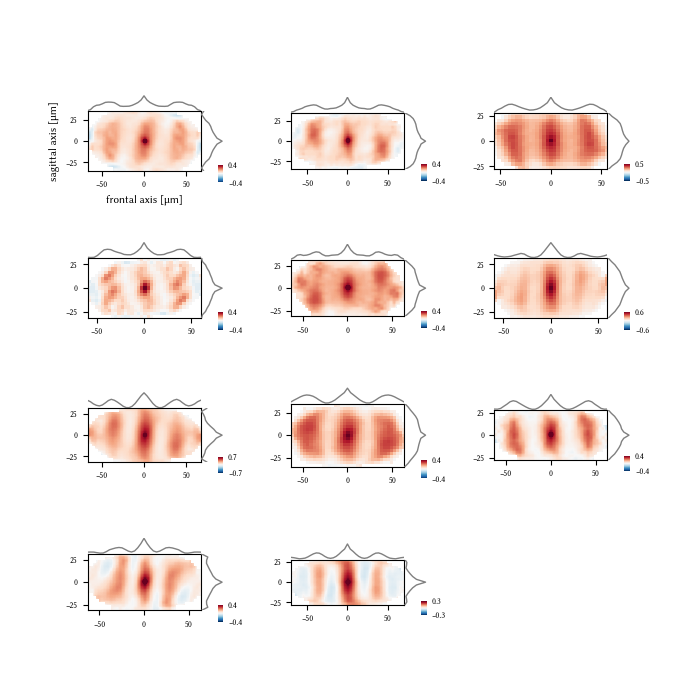

In [11]:
px_size = 0.35

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(4, 3, wspace=0.5, hspace=0.5)

for i in range(len(pooled)):
    subgs = GridSpecFromSubplotSpec(2, 2, gs[i], width_ratios=[10,2], height_ratios=[2,10], wspace=0, hspace=0)
    
    ax = fig.add_subplot(subgs[1,0])
    mx = pooled[i]
    x_size, y_size = mx.shape
    x_ext = (x_size//2)*bin_px*px_size
    y_ext = (y_size//2)*bin_px*px_size
    lim = np.ceil(np.maximum(np.nanmax(mx[mx!=1]), abs(np.nanmin(mx)))*10)/10
    im = ax.imshow(mx.T, vmin=-lim, vmax=lim, extent=(-x_ext, x_ext, -y_ext, y_ext), cmap='RdBu_r', origin="upper")
    ax.xaxis.set(ticks_position='bottom')
    ax.tick_params(labelsize=6)
    ax.set(aspect="equal", xticks=(-50, 0, 50), yticks=(-25, 0, 25))
    if i == 0:
        ax.set(xlabel="frontal axis [μm]", ylabel="sagittal axis [μm]")
    mx_bbox = ax.get_position()
    add_cbar(im, ax, inset_loc=(1.2, -0.1, 0.05, 0.3), ticks=(-lim,lim), labelsize=6)

    ax = fig.add_subplot(subgs[0,0])
    bbox = ax.get_position()
    ax.plot(x_pooled[i], c='gray', linewidth=1)
    ax.margins(x=0)
    ax.set(position=[mx_bbox.x0, mx_bbox.y0+mx_bbox.height, mx_bbox.width, bbox.height])
    ax.axis('off')

    ax = fig.add_subplot(subgs[1,1])
    bbox = ax.get_position()
    ax.plot(y_pooled[i], range(y_size), c='gray', linewidth=1)
    ax.margins(y=0)
    ax.set(position=[mx_bbox.x0+mx_bbox.width, mx_bbox.y0, bbox.width, mx_bbox.height])
    ax.axis('off')